- abstract type: soil, pools, elements
- abstract type: parameters, soil and plant, 

In [1]:
## note1: qom_dom was put in flux!(DOM) and struct DOM 
# import Pkg; Pkg.add("DataFrames")
# import Pkg; Pkg.add("StatsPlots")
using StatsPlots
using Plots
using UnPack
using DataFrames
using CSV

In [2]:
Base.@kwdef mutable struct SoilPar
    "parameters"
    fRa::Float64 = 0.2
    fINP::Float64 = 0.3
    vd_pomo::Float64   = 50.0
    vd_pomh::Float64   = 50.0
    vd_mom::Float64    = vd_pomh * 0.01
    ks_pomo::Float64   = 60.0
    fKM::Float64       = 10.0
    ks_pomh::Float64   = ks_pomo/fKM
    ks_mom::Float64    = ks_pomo * fKM
    Qmax::Float64      = 1.5
    Kba::Float64       = 6.0 
    Kdes::Float64      = 0.006 
    Kads::Float64      = Kdes * Kba    
    Kp2u::Float64      = 0.000005
    Ku2p::Float64      = 0.001
    rENZM::Float64     = 0.00012289
    rENZPo::Float64    = rENZM
    rENZPh::Float64    = rENZM
    pENZP::Float64     = 0.00147568
    fpEM::Float64      = 4.50361918
    pENZM::Float64     = pENZP * fpEM    
    frPOM2DOM::Float64 = 0.75
    frMB2DOM::Float64  = 0.5
    frMBA_to_POMo::Float64 = 0.1
    frMBA_to_POMh::Float64 = 0.9
    Vg::Float64        = 0.00425194
    alpha::Float64     = 0.05012233
    Vm::Float64        = Vg * alpha/(1.0 - alpha)
    KsDOM::Float64     = 0.00010034
    Yg::Float64        = 0.20109320 
    Ygsl::Float64      = 0.00520677
    CUE_slope::Float64 = -1.0*Ygsl
    Q10::Float64       = 2.0 #1.8
    gamma::Float64     = 0.01030726
    rMORT::Float64     = min(0.99,Vm * gamma)
    beta::Float64      = 0.001
    VmD::Float64       = Vm * beta
    VmA2D::Float64     = Vm #* tp_scalar * wp_scalar_low
    VmD2A::Float64     = Vm #* tp_scalar * wp_scalar
    SWP_A2D::Float64   = 0.46
    tau::Float64       = 0.39
    SWP_D2A::Float64   = tau * SWP_A2D
    wdorm::Float64     = 3.38
    VNup_MB::Float64   = 0.1
    VNup_VG::Float64   = 0.00003296
    rNleach::Float64   = 0.02
    bNup_VG::Float64   = 0.5
    KsNH4_MB::Float64  = 0.00018
    KsNO3_MB::Float64  = 0.00041
    # YgN = sPAR%YgN        = phi 
    Qmax_NH4::Float64  = 0.0057442
    Kba_NH4::Float64   = 100.0
    KsNH4_VG::Float64  = 0.0012
    KsNO3_VG::Float64  = 0.0018
    fpENZN::Float64    = 1.0
    VNif::Float64      = 0.0635041
    VNit::Float64      = 185.28188371
    VDenit::Vector{Float64} = [0.86952628,0.86952628,0.86952628,0.86952628]
    # VDenit(1) = 0.86952628
    # VDenit(2) = 0.86952628
    # VDenit(3) = 0.86952628
    # VDenit(4) = 0.86952628
    KsNif::Float64 = 0.1
    KsNit::Float64 = 0.0012
    KsDenit::Vector{Float64} = [0.0018,0.0018,0.0018,0.0018]
    # KsDenit(1) = 0.0018
    # KsDenit(2) = 0.0018
    # KsDenit(3) = 0.0018
    # KsDenit(4) = 0.0018 
    
end

SoilPar

In [3]:
mutable struct Pools{FT<:AbstractFloat}
    POMo::FT
    POMh::FT
    MOM ::FT
    DOM ::FT
    QOM ::FT
    MBA ::FT 
    MBD ::FT
    EPO ::FT 
    EPH ::FT 
    EM  ::FT 
end

Base.@kwdef mutable struct Fluxes{FT<:AbstractFloat}
    pomo_dom ::FT = 0.0
    pomo_mom ::FT = 0.0
    pomh_dom ::FT = 0.0
    pomh_mom ::FT = 0.0
    mom_dom ::FT  = 0.0
    dom_mba ::FT  = 0.0
    dom_qom ::FT  = 0.0
    qom_dom ::FT  = 0.0
    co2_maintn_mba ::FT = 0.0
    co2_growth     ::FT = 0.0
    mba_pomh ::FT = 0.0
    mba_pomo ::FT = 0.0
    mba_dom  ::FT = 0.0
    mba_mbd  ::FT = 0.0
    mba_eph  ::FT = 0.0
    mba_epo  ::FT = 0.0
    mba_em   ::FT = 0.0
    mbd_mba  ::FT = 0.0
    co2_maintn_mbd ::FT = 0.0
end


In [4]:
struct Flux_POMo end 
struct Flux_POMh end 
struct Flux_MOM end
struct Flux_DOM end
struct Flux_MBA end
struct Flux_MBD end



In [5]:
##1 all Michaelis-Menten equations

function MM(par::SoilPar,pools::Pools,::Type{Flux_POMo}) 
    @unpack vd_pomo, ks_pomo  = par
    @unpack POMo, EPO = pools
    vm = vd_pomo   
    km = ks_pomo
    substrate = POMo
    enzyme = EPO 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::Pools,::Type{Flux_POMh}) 
    @unpack vd_pomh, ks_pomh  = par
    @unpack POMh, EPH = pools
    vm = vd_pomh   
    km = ks_pomh
    substrate = POMh
    enzyme = EPH 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::Pools,::Type{Flux_MOM}) 
    @unpack vd_mom, ks_mom  = par
    @unpack MOM, EM = pools
    vm = vd_mom   
    km = ks_mom
    substrate = MOM
    enzyme = EM 
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::Pools,::Type{Flux_DOM}) 
    @unpack Vg, Vm, Yg, KsDOM  = par
    @unpack DOM, MBA = pools
    vm = (Vg + Vm)/Yg    
    km = KsDOM
    substrate = DOM
    enzyme = MBA
        
    MM = vm * substrate * enzyme/(km + substrate)
    MM = min(MM, substrate)
    return MM
end

function MM(par::SoilPar,pools::Pools,::Type{Flux_MBA}) 
    @unpack Vg, Yg, KsDOM, Vm  = par
    @unpack MBA,DOM = pools
    enzyme    = MBA 
    substrate = DOM
    vm = Vg * (1.0/Yg - 1.0)   
    km = KsDOM
        
    MM_growth = vm * substrate * enzyme/(km + substrate)
    MM_growth = min(MM_growth, substrate)

    vm = Vm * (1.0/Yg - 1.0)
    MM_maintn = vm * substrate * enzyme/(km + substrate)
    MM_maintn = min(MM_maintn, substrate)
    return MM_growth, MM_maintn
end



MM (generic function with 5 methods)

In [6]:
##2 develop functions: Fluxes

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_POMo})
    @unpack frPOM2DOM = par
    pomo_dec = MM(par,pools,Flux_POMo)
    pomo_dom = frPOM2DOM * pomo_dec
    pomo_mom = (1.0 - frPOM2DOM) * pomo_dec  

    flux.pomo_dom = pomo_dom
    flux.pomo_mom = pomo_mom 
    return pomo_dom,pomo_mom  
end

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_POMh})
    @unpack frPOM2DOM = par
    pomh_dec = MM(par,pools,Flux_POMh)
    pomh_dom = frPOM2DOM * pomh_dec
    pomh_mom = (1.0 - frPOM2DOM) * pomh_dec 

    flux.pomh_dom = pomh_dom
    flux.pomh_mom = pomh_mom 
    return pomh_dom,pomh_mom  
end

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_MOM})
    mom_dec      = MM(par,pools,Flux_MOM)
    mom_dom      = mom_dec

    flux.mom_dom = mom_dom
    return mom_dom 
end

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_DOM})
    @unpack DOM,QOM = pools 
    @unpack Kads,Qmax,Kdes = par
    dom_dec = MM(par,pools,Flux_DOM)
    dom_mba = dom_dec 
    
    # ========================
    # ads,des = AdsDesorption(par,pools) 
    _DOM = DOM - dom_mba # the preference given to microbial uptake then ad_de
    adsorbate = _DOM
    adsorbent = QOM
    ads = Kads * adsorbate * (1.0 - adsorbent/Qmax)
    des = Kdes * adsorbent / Qmax
    if des > (adsorbent + ads)
        des = adsorbent + ads 
    elseif ads > adsorbate + des 
        ads = adsorbate + des
    end 
    # ========================
    dom_qom = ads  
    qom_dom = des

    flux.dom_mba = dom_mba
    flux.dom_qom = dom_qom
    flux.qom_dom = qom_dom
    return dom_mba, dom_qom, qom_dom 
end

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_MBA})
    @unpack rMORT, frMB2DOM, frMBA_to_POMh, frMBA_to_POMo, KsDOM, VmA2D = par
    @unpack MBA,DOM = pools 
    mb = MBA
    mba_mortality= rMORT * mb
    mba_dom   = frMB2DOM * mba_mortality
    mba_pomh   = (1.0 - frMB2DOM) * mba_mortality * frMBA_to_POMh
    mba_pomo   = (1.0 - frMB2DOM) * mba_mortality * frMBA_to_POMo
    
    phi = DOM/(DOM + KsDOM)
    mba_mbd = (1.0 - phi) * VmA2D * mb
    mba_CO2_growth, mba_CO2_maintn = MM(par,pools,Flux_MBA) # Respiration of MBA

    flux.mba_dom        = mba_dom
    flux.mba_pomo       = mba_pomo
    flux.mba_pomh       = mba_pomh
    flux.mba_mbd        = mba_mbd
    flux.co2_growth = mba_CO2_growth
    flux.co2_maintn_mba = mba_CO2_maintn
    return mba_mortality,mba_dom,mba_pomo,mba_pomh,mba_mbd,mba_CO2_growth,mba_CO2_maintn
end

function Flux!(par::SoilPar,pools::Pools,flux::Fluxes,::Type{Flux_MBD}) # Respiration of MBD and resurcitaion
    @unpack KsDOM,VmD2A,VmD = par
    @unpack DOM,MBD = pools
    phi = DOM/(DOM + KsDOM)
    mbd_mba = phi * VmD2A * MBD
    mbd_CO2_maintn = VmD * MBD 

    flux.mbd_mba        = mbd_mba
    flux.co2_maintn_mbd = mbd_CO2_maintn
    return mbd_mba, mbd_CO2_maintn
end




Flux! (generic function with 6 methods)

In [7]:
## 3 developing functions: enzymes

function EnzymeProduction(par::SoilPar,pools::Pools)
    @unpack pENZP, Vm, pENZM = par
    @unpack MBA,POMo,POMh = pools 
    
    frPOMh = POMh/(POMh + POMo)
    mba_enzph = frPOMh * pENZP * Vm * MBA
    mba_enzpo = (1-frPOMh) * pENZP * Vm * MBA
    mba_enzm =  pENZM * Vm * MBA
    return mba_enzph, mba_enzpo, mba_enzm 
end 

function EnzymeTurnover(par::SoilPar,pools::Pools)
    epo_dom = par.rENZPo * pools.EPO
    eph_dom = par.rENZPh * pools.EPH
    em_dom  = par.rENZM * pools.EM
    return epo_dom,eph_dom,em_dom
end


EnzymeTurnover (generic function with 1 method)

In [8]:
##4.1 developing functions: carbon pools 
function CPools!(par::SoilPar,pools::Pools,fluxes::Fluxes,input_c)
    @unpack POMo,POMh,MOM,DOM,QOM,MBA,MBD,EPO,EPH,EM = pools
    # @unpack EPO,EPH,EM = pools
    litter_pomo = input_c.litter_pomo_array
    litter_pomh = input_c.litter_pomh_array
    litter_dom = input_c.litter_dom_array

    pomo_dec = MM(par,pools,Flux_POMo); pomh_dec = MM(par,pools,Flux_POMh);
    mom_dec = MM(par,pools,Flux_MOM); dom_dec = MM(par,pools,Flux_DOM);

    pomo_dom,pomo_mom = Flux!(par,pools,fluxes,Flux_POMo)
    pomh_dom,pomh_mom = Flux!(par,pools,fluxes,Flux_POMh)
    dom_mba, dom_qom, qom_dom = Flux!(par,pools,fluxes,Flux_DOM)
    
    mba_mortality, mba_dom, mba_pomo, mba_pomh,
    mba_mbd, mba_CO2_growth, mba_CO2_maintn = 
    Flux!(par,pools,fluxes,Flux_MBA);

    mbd_mba, mbd_CO2_maintn = Flux!(par,pools,fluxes,Flux_MBD)

    epo_dom,eph_dom,em_dom = EnzymeTurnover(par,pools)

    mba_eph, mba_epo, mba_em = EnzymeProduction(par,pools)

    pools.POMo = POMo - pomo_dec + mba_pomo + litter_pomo
    pools.POMh = POMh - pomh_dec + mba_pomh + litter_pomh
    pools.MOM = MOM - mom_dec + pomo_mom + pomh_mom 
    pools.DOM = (DOM - dom_dec - dom_qom + qom_dom + litter_dom + pomh_dom 
                + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom)
    pools.QOM = QOM - qom_dom + dom_qom

    pools.MBA = (MBA - mba_mortality - mba_mbd - mba_CO2_growth 
                - mba_CO2_maintn + dom_mba + mbd_mba
                - mba_eph - mba_epo - mba_em)

    pools.MBD = MBD - mbd_mba - mbd_CO2_maintn + mba_mbd

    pools.EPO = EPO + mba_epo - epo_dom
    pools.EPH = EPH + mba_eph - eph_dom
    pools.EM = EM + mba_em - em_dom
    
    return nothing 
end

CPools! (generic function with 1 method)

In [34]:
##4.2 testing new mechanisms: diveristy of metabolites and functional groups
Base.@kwdef mutable struct par_DOM_MFG
    Vg1::Float64 = 0.00425194
    # alpha::Float64     = 0.05012233
    Vm1::Float64       = 0.00022436  #Vg1 * alpha/(1.0 - alpha)
    Yg1::Float64 = 0.20109320 
    KsDOM1::Float64 = 0.00010034

    Vg2::Float64 = 0.00425194/1.0 #4.0
    Vm2::Float64 = 0.00022436/1.0 #4.0
    Yg2::Float64 = 0.20109320 * 1.0 #2.0
    KsDOM2::Float64 = 0.00010034/1.0 # 4.0
    
    # Vg2::Float64 = 0.00425194/4.0
    # Vm2::Float64 = 0.00022436/4.0
    # Yg2::Float64 = 0.20109320 * 2.0
    # KsDOM2::Float64 = 0.00010034/4.0
end

mutable struct divDOM
    dom1::Float64
    dom2::Float64
    dom3::Float64
end
# struct Flux_dom1 end
# struct Flux_dom2 end 
# struct Flux_dom3 end 

mutable struct MFGroup 
    mfg1::Float64
    mfg2::Float64
end 

function MM(par::par_DOM_MFG,dom,mfg::MFGroup) 
    @unpack Vg1, Vm1, Yg1, KsDOM1  = par
    @unpack Vg2, Vm2, Yg2, KsDOM2  = par

    # @unpack dom1,dom2,dom3         = doms
    @unpack mfg1, mfg2             = mfg
    vm1 = (Vg1 + Vm1)/Yg1    
    km1 = KsDOM1
    substrate = dom

    vm2 = (Vg2 + Vm2)/Yg2    
    km2 = KsDOM2
    # substrate2 = dom2


    enzyme1 = mfg1
    enzyme2 = mfg2
        
    MM_mfg1 = vm1 * substrate * enzyme1/(km1*(1 + substrate/km1 + enzyme1/km1 + enzyme2/km2))
    
    MM_mfg2 = vm2 * substrate * enzyme2/(km2*(1 + substrate/km2 + enzyme1/km2 + enzyme2/km1))

    if MM_mfg1 + MM_mfg2 > substrate
        MM_mfg1 = 2.0/3.0 * substrate
        MM_mfg2 = substrate - MM_mfg1
    end 

    return MM_mfg1, MM_mfg2
end

function CPools!(par::SoilPar,pools::Pools,fluxes::Fluxes,input_c,
                 doms::divDOM,mfgs::MFGroup,par_dom::par_DOM_MFG)
    @unpack POMo,POMh,MOM,DOM,QOM,MBA,MBD,EPO,EPH,EM = pools
    @unpack dom1,dom2,dom3 = doms
    @unpack mfg1,mfg2 = mfgs
    # @unpack EPO,EPH,EM = pools
    litter_pomo = input_c.litter_pomo_array
    litter_pomh = input_c.litter_pomh_array
    litter_dom = input_c.litter_dom_array

    pomo_dec = MM(par,pools,Flux_POMo); pomh_dec = MM(par,pools,Flux_POMh);
    mom_dec = MM(par,pools,Flux_MOM); dom_dec = MM(par,pools,Flux_DOM);

    # ============================================
    par_dom1 = par_DOM_MFG()
    dom1_mfg1,dom1_mfg2 = MM(par_dom1,dom1,mfgs)

    par_dom2 = par_DOM_MFG();_scalarx = 1.0/20.0 # 2.0
    par_dom2.Vg1/=_scalarx;par_dom2.Vm1/=_scalarx;par_dom2.Yg1/=_scalarx;par_dom2.KsDOM1/=_scalarx
    par_dom2.Vg2/=_scalarx;par_dom2.Vm2/=_scalarx;par_dom2.Yg2/=_scalarx;par_dom2.KsDOM2/=_scalarx
    dom2_mfg1,dom2_mfg2 = MM(par_dom2,dom2,mfgs)

    par_dom3 = par_DOM_MFG();_scalary = 1.0/40.0 # 4.0
    par_dom3.Vg1/=_scalary;par_dom3.Vm1/=_scalary;par_dom3.Yg1/=_scalary;par_dom3.KsDOM1/=_scalary
    par_dom3.Vg2/=_scalary;par_dom3.Vm2/=_scalary;par_dom3.Yg2/=_scalary;par_dom3.KsDOM2/=_scalary
    dom3_mfg1,dom3_mfg2 = MM(par_dom3,dom3,mfgs)
    # =======================================

    pomo_dom,pomo_mom = Flux!(par,pools,fluxes,Flux_POMo)
    pomh_dom,pomh_mom = Flux!(par,pools,fluxes,Flux_POMh)
    dom_mba, dom_qom, qom_dom = Flux!(par,pools,fluxes,Flux_DOM)
    
    mba_mortality, mba_dom, mba_pomo, mba_pomh,
    mba_mbd, mba_CO2_growth, mba_CO2_maintn = 
    Flux!(par,pools,fluxes,Flux_MBA);

    mbd_mba, mbd_CO2_maintn = Flux!(par,pools,fluxes,Flux_MBD)

    epo_dom,eph_dom,em_dom = EnzymeTurnover(par,pools)

    mba_eph, mba_epo, mba_em = EnzymeProduction(par,pools)

    pools.POMo = POMo - pomo_dec + mba_pomo + litter_pomo
    pools.POMh = POMh - pomh_dec + mba_pomh + litter_pomh
    pools.MOM = MOM - mom_dec + pomo_mom + pomh_mom 

    # ========================================
    dom_dec = dom1_mfg1 + dom1_mfg2 + dom2_mfg1 + dom2_mfg2 + dom3_mfg1 + dom3_mfg2
    source_dom = litter_dom + pomh_dom + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom
    doms.dom1 = (dom1 - dom1_mfg1 - dom1_mfg2 + source_dom/3.0)
    doms.dom2 = (dom2 - dom2_mfg1 - dom2_mfg2 + source_dom/3.0)
    doms.dom3 = (dom3 - dom3_mfg1 - dom3_mfg2 + source_dom/3.0)
    pools.DOM = doms.dom1+doms.dom2+doms.dom3

    # pools.DOM = (DOM - dom_dec - dom_qom + qom_dom + litter_dom + pomh_dom 
    #             + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom)
    # ========================================
    # pools.QOM = QOM - qom_dom + dom_qom
    dom_mba = dom1_mfg1 + dom1_mfg2+ dom2_mfg1 + dom2_mfg2 + dom3_mfg1 + dom3_mfg2
    _scalar1 = mfg1/(mfg1+mfg2)
    others  =  (- mba_mbd - mba_CO2_growth - mba_CO2_maintn + dom_mba + mbd_mba
                - mba_eph - mba_epo - mba_em)
    mfgs.mfg1 = (mfg1 - mba_mortality * _scalar1*1.2) + others*_scalar1
    mfgs.mfg2 = (mfg2 - mba_mortality * (1.0-_scalar1*1.2)) + others*(1.0-_scalar1)

    pools.MBA = mfgs.mfg1 + mfgs.mfg2

    pools.MBD = MBD - mbd_mba - mbd_CO2_maintn + mba_mbd
    # ====================================================================
    pools.EPO = EPO + mba_epo - epo_dom
    pools.EPH = EPH + mba_eph - eph_dom
    pools.EM = EM + mba_em - em_dom
    
    return nothing 
end

CPools! (generic function with 4 methods)

In [26]:
##4.3 testing new mechanisms: diveristy of metabolites only

function MM(par::par_DOM_MFG,pools::Pools,dom)#,mfg::MFGroup) 
    @unpack Vg1, Vm1, Yg1, KsDOM1  = par
    # @unpack Vg2, Vm2, Yg2, KsDOM2  = par

    # @unpack dom1,dom2,dom3         = doms
    # @unpack mfg1, mfg2             = mfg
    vm1 = (Vg1 + Vm1)/Yg1    
    km1 = KsDOM1
    substrate = dom

    # vm2 = (Vg2 + Vm2)/Yg2    
    # km2 = KsDOM2
    # substrate2 = dom2


    enzyme1 = pools.MBA
    # enzyme2 = mfg2
        
    # MM_mfg1 = vm1 * substrate * enzyme1/(km1*(1 + substrate/km1 + enzyme1/km1 + enzyme2/km2))
    
    # MM_mfg2 = vm2 * substrate * enzyme2/(km2*(1 + substrate/km2 + enzyme1/km2 + enzyme2/km1))
    MM = vm1 * substrate * enzyme1/(km1 + substrate)
    MM = min(MM, substrate)
    

    return MM
end

function CPools!(par::SoilPar,pools::Pools,fluxes::Fluxes,input_c,
                 doms::divDOM,par_dom::par_DOM_MFG)
    @unpack POMo,POMh,MOM,DOM,QOM,MBA,MBD,EPO,EPH,EM = pools
    @unpack dom1,dom2,dom3 = doms
    # @unpack mfg1,mfg2 = mfgs
    # @unpack EPO,EPH,EM = pools
    litter_pomo = input_c.litter_pomo_array
    litter_pomh = input_c.litter_pomh_array
    litter_dom = input_c.litter_dom_array

    pomo_dec = MM(par,pools,Flux_POMo); pomh_dec = MM(par,pools,Flux_POMh);
    mom_dec = MM(par,pools,Flux_MOM); dom_dec = MM(par,pools,Flux_DOM);

    # ============================================
    par_dom1 = par_DOM_MFG()
    dom1_mfg = MM(par_dom1,pools,dom1)

    par_dom2 = par_DOM_MFG();_scalarx = 1.0/20.0
    par_dom2.Vg1/=_scalarx;par_dom2.Vm1/=_scalarx;par_dom2.Yg1/=_scalarx;par_dom2.KsDOM1/=_scalarx
    par_dom2.Vg2/=_scalarx;par_dom2.Vm2/=_scalarx;par_dom2.Yg2/=_scalarx;par_dom2.KsDOM2/=_scalarx
    dom2_mfg = MM(par_dom2,pools,dom2)

    par_dom3 = par_DOM_MFG(); _scalary = 1.0/40.0
    par_dom3.Vg1/=_scalary;par_dom3.Vm1/=_scalary;par_dom3.Yg1/=_scalary;par_dom3.KsDOM1/=_scalary
    par_dom3.Vg2/=_scalary;par_dom3.Vm2/=_scalary;par_dom3.Yg2/=_scalary;par_dom3.KsDOM2/=_scalary
    dom3_mfg = MM(par_dom3,pools,dom3)
    # =======================================

    pomo_dom,pomo_mom = Flux!(par,pools,fluxes,Flux_POMo)
    pomh_dom,pomh_mom = Flux!(par,pools,fluxes,Flux_POMh)
    dom_mba, dom_qom, qom_dom = Flux!(par,pools,fluxes,Flux_DOM)
    
    mba_mortality, mba_dom, mba_pomo, mba_pomh,
    mba_mbd, mba_CO2_growth, mba_CO2_maintn = 
    Flux!(par,pools,fluxes,Flux_MBA);

    mbd_mba, mbd_CO2_maintn = Flux!(par,pools,fluxes,Flux_MBD)

    epo_dom,eph_dom,em_dom = EnzymeTurnover(par,pools)

    mba_eph, mba_epo, mba_em = EnzymeProduction(par,pools)

    pools.POMo = POMo - pomo_dec + mba_pomo + litter_pomo
    pools.POMh = POMh - pomh_dec + mba_pomh + litter_pomh
    pools.MOM = MOM - mom_dec + pomo_mom + pomh_mom 

    # ========================================
    # dom_dec = dom1_mfg1 + dom1_mfg2 + dom2_mfg1 + dom2_mfg2 + dom3_mfg1 + dom3_mfg2
    source_dom = litter_dom + pomh_dom + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom
    doms.dom1 = (dom1 - dom1_mfg  + source_dom/3.0)
    doms.dom2 = (dom2 - dom2_mfg  + source_dom/3.0)
    doms.dom3 = (dom3 - dom3_mfg  + source_dom/3.0)
    pools.DOM = doms.dom1+doms.dom2+doms.dom3

    # pools.DOM = (DOM - dom_dec - dom_qom + qom_dom + litter_dom + pomh_dom 
    #             + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom)
    # ========================================
    # pools.QOM = QOM - qom_dom + dom_qom
    dom_mba = dom1_mfg + dom2_mfg + dom3_mfg

    pools.MBA = (MBA - mba_mortality - mba_mbd - mba_CO2_growth 
                - mba_CO2_maintn + dom_mba + mbd_mba
                - mba_eph - mba_epo - mba_em)

    pools.MBD = MBD - mbd_mba - mbd_CO2_maintn + mba_mbd
    # ====================================================================
    pools.EPO = EPO + mba_epo - epo_dom
    pools.EPH = EPH + mba_eph - eph_dom
    pools.EM = EM + mba_em - em_dom
    
    return nothing 
end

CPools! (generic function with 3 methods)

In [31]:
##4.4 testing new mechanisms: functional groups


function MM(par::par_DOM_MFG,pools::Pools,mfg::MFGroup) 
    @unpack Vg1, Vm1, Yg1, KsDOM1  = par
    @unpack Vg2, Vm2, Yg2, KsDOM2  = par

    # @unpack dom1,dom2,dom3         = doms
    @unpack mfg1, mfg2             = mfg
    vm1 = (Vg1 + Vm1)/Yg1    
    km1 = KsDOM1
    substrate = pools.DOM

    vm2 = (Vg2 + Vm2)/Yg2    
    km2 = KsDOM2
    # substrate2 = dom2


    enzyme1 = mfg1
    enzyme2 = mfg2
        
    MM_mfg1 = vm1 * substrate * enzyme1/(km1*(1 + substrate/km1 + enzyme1/km1 + enzyme2/km2))
    
    MM_mfg2 = vm2 * substrate * enzyme2/(km2*(1 + substrate/km2 + enzyme1/km2 + enzyme2/km1))

    if MM_mfg1 + MM_mfg2 > substrate
        MM_mfg1 = 2.0/3.0 * substrate
        MM_mfg2 = substrate - MM_mfg1
    end 

    return MM_mfg1, MM_mfg2
end

function CPools!(par::SoilPar,pools::Pools,fluxes::Fluxes,input_c,
                 mfgs::MFGroup,par_dom::par_DOM_MFG)
    @unpack POMo,POMh,MOM,DOM,QOM,MBA,MBD,EPO,EPH,EM = pools
    # @unpack dom1,dom2,dom3 = doms
    @unpack mfg1,mfg2 = mfgs
    # @unpack EPO,EPH,EM = pools
    litter_pomo = input_c.litter_pomo_array
    litter_pomh = input_c.litter_pomh_array
    litter_dom = input_c.litter_dom_array

    pomo_dec = MM(par,pools,Flux_POMo); pomh_dec = MM(par,pools,Flux_POMh);
    mom_dec = MM(par,pools,Flux_MOM); dom_dec = MM(par,pools,Flux_DOM);

    # ============================================
    par_dom = par_DOM_MFG()
    dom_mfg1,dom_mfg2 = MM(par_dom,pools,mfgs)
    # =======================================

    pomo_dom,pomo_mom = Flux!(par,pools,fluxes,Flux_POMo)
    pomh_dom,pomh_mom = Flux!(par,pools,fluxes,Flux_POMh)
    dom_mba, dom_qom, qom_dom = Flux!(par,pools,fluxes,Flux_DOM)
    
    mba_mortality, mba_dom, mba_pomo, mba_pomh,
    mba_mbd, mba_CO2_growth, mba_CO2_maintn = 
    Flux!(par,pools,fluxes,Flux_MBA);

    mbd_mba, mbd_CO2_maintn = Flux!(par,pools,fluxes,Flux_MBD)

    epo_dom,eph_dom,em_dom = EnzymeTurnover(par,pools)

    mba_eph, mba_epo, mba_em = EnzymeProduction(par,pools)

    pools.POMo = POMo - pomo_dec + mba_pomo + litter_pomo
    pools.POMh = POMh - pomh_dec + mba_pomh + litter_pomh
    pools.MOM = MOM - mom_dec + pomo_mom + pomh_mom 

    # ========================================
    dom_dec = dom_mfg1 + dom_mfg2 
    # source_dom = litter_dom + pomh_dom + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom
    # doms.dom1 = (dom1 - dom1_mfg1 - dom1_mfg2 + source_dom/3.0)
    # doms.dom2 = (dom2 - dom2_mfg1 - dom2_mfg2 + source_dom/3.0)
    # doms.dom3 = (dom3 - dom3_mfg1 - dom3_mfg2 + source_dom/3.0)
    # pools.DOM = doms.dom1+doms.dom2+doms.dom3

    pools.DOM = (DOM - dom_dec + litter_dom + pomh_dom 
                + pomo_dom + mba_dom + epo_dom + eph_dom + em_dom)
    # ========================================
    # pools.QOM = QOM - qom_dom + dom_qom
    dom_mba = dom_mfg1 + dom_mfg2
    _scalar1 = mfg1/(mfg1+mfg2)
    others  =  (- mba_mbd - mba_CO2_growth - mba_CO2_maintn + dom_mba + mbd_mba
                - mba_eph - mba_epo - mba_em)
    mfgs.mfg1 = (mfg1 - mba_mortality * _scalar1*1.2) + others*_scalar1
    mfgs.mfg2 = (mfg2 - mba_mortality * (1.0-_scalar1*1.2)) + others*(1.0-_scalar1)

    pools.MBA = mfgs.mfg1 + mfgs.mfg2

    pools.MBD = MBD - mbd_mba - mbd_CO2_maintn + mba_mbd
    # ====================================================================
    pools.EPO = EPO + mba_epo - epo_dom
    pools.EPH = EPH + mba_eph - eph_dom
    pools.EM = EM + mba_em - em_dom
    
    return nothing 
end

CPools! (generic function with 4 methods)

In [11]:
# parameters for temperature dependence 
function ParTemp!(par::SoilPar,T::Float64)
    @unpack vd_pomh,vd_pomo,vd_mom = par 
    @unpack Yg, Vg, Vm, Q10 = par
    Tref = 20.0
    fTQ10 = Q10^((T-Tref)/10.0)

    par.vd_pomh = vd_pomh*fTQ10
    par.vd_pomo = vd_pomo*fTQ10
    par.vd_mom  = vd_mom*fTQ10
    par.Yg      = Yg*fTQ10
    
    return nothing
end
# function fTQ10(T, Q10, Tref=20.0)
#     fTQ10 = Q10^((T-Tref)/10.0)
# end


ParTemp! (generic function with 1 method)

In [9]:
##5 Initialize the model

function InitCPools()

    # scalar = 100.0/100.0 #sl_dif[ilayer]
    soc = 1.578  
    poc = 0.377 
    poc_o = poc * LF0; poc_h = poc * (1.0 - LF0); 

    moc = 1.064
    qoc = moc * fQOM; 

    doc = 0.137 

    mbc = 0.033 
    mbc_a = mbc * r0; mbc_d = mbc * (1.0 - r0);

    epo = 6.0e-5 
    eph = 6.0e-5 
    em  = 6.0e-5 

    # _CPools = CPools(10000.,10000.,2000.,200.,120.,100.,150.,0.1,0.1,0.1)
    cpools = Pools(poc_o,poc_h,moc,doc,qoc,mbc_a,mbc_d,epo,eph,em)
    return cpools
end

function InitCFluxes()
    cfluxes = Fluxes()
    return cfluxes
end

function InitCInputs(par)


    SIN_day_str = readlines("./SIN_day.dat") # unit: mgC-cm2-d

    SIN_day = parse.(Float64, SIN_day_str) # string to numeric

    SIN_day = SIN_day[3:end]

    SIN_hour = SIN_day ./24

    SIN_input = SIN_hour .* par.fINP;
    

    # 0.07, 0.37, 0.56 # fraction type I
    f_l_pomo = 0.07 # to be added to parameter list 
    f_l_pomh = 0.37 # to be added to parameter list
    f_l_dom = 0.56 # to be added to parameter list
    depth = 100.0
    litter_pomo_array = SIN_input .* (f_l_pomo/depth)
    litter_pomh_array = SIN_input .* (f_l_pomh/depth)
    litter_dom_array  = SIN_input .* (f_l_dom/depth)
    input_c = DataFrame()
    input_c[!,"litter_pomo_array"] = litter_pomo_array
    input_c[!,"litter_pomh_array"] = litter_pomh_array
    input_c[!,"litter_dom_array"]  = litter_dom_array
    return input_c
end


InitCInputs (generic function with 1 method)

In [10]:
## create dataframe to store output 

function create_dataframe(FT,ncycle,nyear)#(FT,weather::DataFrame)
    
    df    = DataFrame();
   
    df[!, "Time"  ] = zeros(ncycle*nyear*365);
    df[!, "POMh" ] .= FT(0);
    df[!, "POMo" ] .= FT(0);
    df[!, "MOM"  ] .= FT(0);
    df[!, "DOM"  ] .= FT(0);
    df[!, "QOM"    ] .= FT(0);

    
    df[!, "MBA"   ] .= FT(0);
    df[!, "MBD"] .= FT(0);

    return df
end

function create_dataframe(FT,nlayer)#(FT,weather::DataFrame)
    
    df    = DataFrame();
   
    df[!, "Layer"  ] = zeros(nlayer+1);
    df[!, "POMh" ] .= FT(0);
    df[!, "POMo" ] .= FT(0);
    df[!, "MOM"  ] .= FT(0);
    df[!, "DOM"  ] .= FT(0);
    df[!, "QOM"  ] .= FT(0);

    
    df[!, "MBA"] .= FT(0);
    df[!, "MBD"] .= FT(0);

    return df
end

create_dataframe (generic function with 2 methods)

In [11]:
##7.1: model run: default (one DOM and one Functional Group)


function ModRun!(par::SoilPar,cpools::Pools,cfluxes::Fluxes,input_c::DataFrame)
# function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)

    for icycle = 1:ncycle
        for iday = 1:365*nyear
            for ihour = 1:24
                # global litter_pomo = litter_pomo_array[iday]
                # global litter_pomh = litter_pomh_array[iday]
                # global litter_dom = litter_dom_array[iday]
                input_c_time = input_c[iday,:]
                CPools!(par,cpools,cfluxes,input_c_time)
            end
            output_ly[(icycle-1)*365*nyear+iday,"Time"] = (icycle-1)*365*nyear+iday
            output_ly[(icycle-1)*365*nyear+iday,"POMh"] = cpools.POMh
            output_ly[(icycle-1)*365*nyear+iday,"POMo"] = cpools.POMo
            output_ly[(icycle-1)*365*nyear+iday,"MOM"] = cpools.MOM
            output_ly[(icycle-1)*365*nyear+iday,"DOM"] = cpools.DOM
            output_ly[(icycle-1)*365*nyear+iday,"QOM"] = cpools.QOM
            output_ly[(icycle-1)*365*nyear+iday,"MBA"] = cpools.MBA
            output_ly[(icycle-1)*365*nyear+iday,"MBD"] = cpools.MBD
        end 
    end

end 




ModRun! (generic function with 1 method)

In [15]:
##7.2: model run with dom bidiversity & functional groups (2)
function ModRun!(par::SoilPar,cpools::Pools,cfluxes::Fluxes,input_c::DataFrame,
                 doms::divDOM,mfgs::MFGroup,par_dom::par_DOM_MFG)
    # function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)
    
        for icycle = 1:ncycle
            for iday = 1:365*nyear
                for ihour = 1:24
                    # global litter_pomo = litter_pomo_array[iday]
                    # global litter_pomh = litter_pomh_array[iday]
                    # global litter_dom = litter_dom_array[iday]
                    input_c_time = input_c[iday,:]
                    CPools!(par,cpools,cfluxes,input_c_time,doms,mfgs,par_dom)
                end
                output_ly[(icycle-1)*365*nyear+iday,"Time"] = (icycle-1)*365*nyear+iday
                output_ly[(icycle-1)*365*nyear+iday,"POMh"] = cpools.POMh
                output_ly[(icycle-1)*365*nyear+iday,"POMo"] = cpools.POMo
                output_ly[(icycle-1)*365*nyear+iday,"MOM"] = cpools.MOM
                output_ly[(icycle-1)*365*nyear+iday,"DOM"] = cpools.DOM
                output_ly[(icycle-1)*365*nyear+iday,"QOM"] = cpools.QOM
                output_ly[(icycle-1)*365*nyear+iday,"MBA"] = cpools.MBA
                output_ly[(icycle-1)*365*nyear+iday,"MBD"] = cpools.MBD
            end 
        end
    
    end 


ModRun! (generic function with 2 methods)

In [16]:
##7.3: model run with dom bidiversity only
function ModRun!(par::SoilPar,cpools::Pools,cfluxes::Fluxes,input_c::DataFrame,
    doms::divDOM,par_dom::par_DOM_MFG)
# function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)

for icycle = 1:ncycle
for iday = 1:365*nyear
   for ihour = 1:24
       # global litter_pomo = litter_pomo_array[iday]
       # global litter_pomh = litter_pomh_array[iday]
       # global litter_dom = litter_dom_array[iday]
       input_c_time = input_c[iday,:]
       CPools!(par,cpools,cfluxes,input_c_time,doms,par_dom)
   end
   output_ly[(icycle-1)*365*nyear+iday,"Time"] = (icycle-1)*365*nyear+iday
   output_ly[(icycle-1)*365*nyear+iday,"POMh"] = cpools.POMh
   output_ly[(icycle-1)*365*nyear+iday,"POMo"] = cpools.POMo
   output_ly[(icycle-1)*365*nyear+iday,"MOM"] = cpools.MOM
   output_ly[(icycle-1)*365*nyear+iday,"DOM"] = cpools.DOM
   output_ly[(icycle-1)*365*nyear+iday,"QOM"] = cpools.QOM
   output_ly[(icycle-1)*365*nyear+iday,"MBA"] = cpools.MBA
   output_ly[(icycle-1)*365*nyear+iday,"MBD"] = cpools.MBD
end 
end

end 

ModRun! (generic function with 3 methods)

In [30]:
##7.4: model run with functional groups (2) only
function ModRun!(par::SoilPar,cpools::Pools,cfluxes::Fluxes,input_c::DataFrame,
    mfgs::MFGroup,par_dom::par_DOM_MFG)
# function ModRunDepth!(par::SoilPar,cpools::CPools,ilayer::Integer)

for icycle = 1:ncycle
for iday = 1:365*nyear
   for ihour = 1:24
       # global litter_pomo = litter_pomo_array[iday]
       # global litter_pomh = litter_pomh_array[iday]
       # global litter_dom = litter_dom_array[iday]
       input_c_time = input_c[iday,:]
       CPools!(par,cpools,cfluxes,input_c_time,mfgs,par_dom)
   end
   output_ly[(icycle-1)*365*nyear+iday,"Time"] = (icycle-1)*365*nyear+iday
   output_ly[(icycle-1)*365*nyear+iday,"POMh"] = cpools.POMh
   output_ly[(icycle-1)*365*nyear+iday,"POMo"] = cpools.POMo
   output_ly[(icycle-1)*365*nyear+iday,"MOM"] = cpools.MOM
   output_ly[(icycle-1)*365*nyear+iday,"DOM"] = cpools.DOM
   output_ly[(icycle-1)*365*nyear+iday,"QOM"] = cpools.QOM
   output_ly[(icycle-1)*365*nyear+iday,"MBA"] = cpools.MBA
   output_ly[(icycle-1)*365*nyear+iday,"MBD"] = cpools.MBD
end 
end

end 


ModRun! (generic function with 4 methods)

In [14]:

## default main program 
"""
only one layer
"""
nyear=10;ncycle=1;
# par_scenarios = ["con","dec","inc"]
# parameters to be added 
LF0 = 0.1
r0 = 0.01
fQOM = 0.05


# # flux initilization (default values are 0s)
# flux_pomo = Flux_POMo();flux_pomh = Flux_POMh();
# flux_mom = Flux_MOM(); 
# flux_dom = Flux_DOM(); # note: qom is wrapped in dom
# flux_mba = Flux_MBA(); flux_mbd = Flux_MBD();

output_ly = create_dataframe(AbstractFloat,ncycle,nyear);
par = SoilPar();
cpools = InitCPools()
cfluxes = InitCFluxes()
input_c = InitCInputs(par);
# doms = divDOM(cpools.DOM/3.0,cpools.DOM/3.0,cpools.DOM/3.0)
# mfgs = MFGroup(cpools.MBA/2.0,cpools.MBA/2.0)
# par_dom = par_DOM_MFG()
ModRun!(par,cpools,cfluxes,input_c) # default
# ModRun!(par,cpools,cfluxes,input_c,doms,mfgs,par_dom) # both
# ModRun!(par,cpools,cfluxes,input_c,doms,par_dom) # metabolites only
# ModRun!(par,cpools,cfluxes,input_c,mfgs,par_dom) # functional groups

In [40]:
y[end]

7.193981701737263

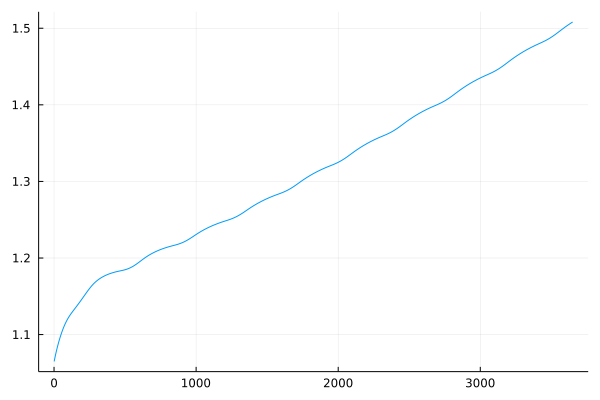

In [16]:
## plots
soc_total = output_ly.MOM  
# soc_total = output_ly.POMo + output_ly.POMh + output_ly.MOM + output_ly.DOM 
x=1:length(soc_total); y = soc_total[1:end] 
plot(x[1:end], y,label=false)
# savefig("test_b.png")

In [64]:
# plotting
# df = DataFrame(Scenarios=["Base","M","F","MF"],SOC=[6015,7152,7215,7215])
# plot(df, x=:Scenarios, y=:SOC, kind="bar")

using Plots 
New_Colors = ["green","blue","purple","brown"]
bar(["Base","Metabolites","Funtional groups","Both"], [6015,7130,7190,7180],
    bar_width=0.65,xtickfontsize=12,ytickfontsize=12,color=New_Colors,
    legend=false,ylabel = "Soil Carbon (g/m2)",dpi=300)#,size=(200,100),) 


savefig("test_xx.png")

In [ ]:
# DONE